# Hansel-Spittle with 6 strain rates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("mime")
import pandas as pd
import h5py
from scipy.optimize import curve_fit
import lmfit

colors = ['#bb0000', '#00bb00', "#0000bb", '#bbbb00', '#bb00bb', "#00bbbb", '#bbbbbb', '#770000', '#007700', "#000077", '#777700', '#770077', "#007777", '#777777', '#440000', '#004400', "#000044", '#444400', '#440044', "#0044444", '#444444','#000000']

In [2]:
baseSize = (8, 6)  # Base size of a subplot

def sbPlot(n):
    if (n == 1): return 1, 1
    if (n <= 2): return 1, 2
    if (n <= 4): return 2, 2
    if (n <= 6): return 3, 2
    if (n <= 9): return 3, 3
    if (n <= 12): return 4, 3
    return 0, 0

def sbPlotSize(n):
    x, y = sbPlot(n)
    return baseSize[0] * y, baseSize[1] * x

In [3]:
h5f = h5py.File('../GleebleData.h5','r')
allData = h5f['all'][:]
shortData = h5f['short'][:]
h5f.close()

In [4]:
allData.shape, shortData.shape

((21030, 4), (1080, 4))

Remove first point of each curve, where $\varepsilon^p=0$

In [5]:
identData = allData[allData[:,0]!=0]
#identData = shortData[shortData[:,0]!=0]

In [6]:
strains = np.unique(identData[:,0])
allStrains = np.unique(allData[:,0])
epsps = np.unique(identData[:,1])
temperatures = np.unique(identData[:,2])
nEps = len(strains)
nEpsp = len(epsps)
nTemp = len(temperatures)
strains, epsps, temperatures, nEps, nEpsp, nTemp

(array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
        0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
        0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
        0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
        0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
        0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
        0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
        0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
        0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
        0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
        0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
        0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108,
        0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117,
        0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125, 0.126,
      

# Identification of the Hansel-Spittel parameters
$\sigma^y = Ae^{(m_1T)}\varepsilon^{p^{m_2}}\dot\varepsilon^{p^{m_3}}e^{(\frac{m_4}{\varepsilon^p})}(1+\varepsilon^p)^{(m_5T)}e^{(m_6\varepsilon^p)}\dot\varepsilon^{p^{(m_7T)}} T^{m_8}$

$\ln \sigma^y = \ln A + m_1T + m_2\ln\varepsilon^p + m_3\ln\dot{\varepsilon^p}+ \frac{m_4}{\varepsilon^p} + m_5T\ln (1+\varepsilon^p) + m_6\varepsilon^p + m_7T\ln \dot{\varepsilon^p} + m_8\ln T$

In [7]:
T0 = temperatures[0]
epsp0 = epsps[0]
Tm = 1460

In [8]:
def HS5(epsp, depsp, T, opt):
    return opt['A'] * np.exp(opt['m1']*T) * epsp**(opt['m2']) * depsp**(opt['m3']) * np.exp(opt['m4']/epsp) * (1+epsp)**(opt['m5']*T)

def HS6(epsp, depsp, T, opt):
    return opt['A'] * np.exp(opt['m1']*T) * epsp**(opt['m2']) * depsp**(opt['m3']) * np.exp(opt['m4']/epsp) * (1+epsp)**(opt['m5']*T) * np.exp(opt['m6']*epsp)

def HS7(epsp, depsp, T, opt):
    return opt['A'] * np.exp(opt['m1']*T) * epsp**(opt['m2']) * depsp**(opt['m3']) * np.exp(opt['m4']/epsp) * (1+epsp)**(opt['m5']*T) * np.exp(opt['m6']*epsp) * depsp**(opt['m7']*T)

def HS8(epsp, depsp, T, opt):
    return opt['A'] * np.exp(opt['m1']*T) * epsp**(opt['m2']) * depsp**(opt['m3']) * np.exp(opt['m4']/epsp) * (1+epsp)**(opt['m5']*T) * np.exp(opt['m6']*epsp) * depsp**(opt['m7']*T) * T**(opt['m8'])

## 5 Parameters

In [9]:
param5 = lmfit.Parameters()
param5.add('A', value = 1e3, min = 0.0)
param5.add('m1', value = 0.1)
param5.add('m2', value = 00.1)
param5.add('m3', value = 00.1)
param5.add('m4', value = 00.1)
param5.add('m5', value = 00.1)
param5

name,value,initial value,min,max,vary
A,1000.00000,1000.0,0.00000000,inf,True
m1,0.10000000,0.1,-inf,inf,True
m2,0.10000000,0.1,-inf,inf,True
m3,0.10000000,0.1,-inf,inf,True
m4,0.10000000,0.1,-inf,inf,True
m5,0.10000000,0.1,-inf,inf,True


In [10]:
def OF5(opt):
    return identData[:,3] - HS5(identData[:,0], identData[:,1], identData[:,2], opt)
fit5 = lmfit.minimize(OF5, param5)
fit5

## 6 Parameters

In [11]:
param6 = lmfit.Parameters()
param6.add('A', value = 1e3, min = 0.0)
param6.add('m1', value = 0)
param6.add('m2', value = 0)
param6.add('m3', value = 0)
param6.add('m4', value = 0)
param6.add('m5', value = 0)
param6.add('m6', value = 0)
param6

name,value,initial value,min,max,vary
A,1000.00000,1000.0,0.00000000,inf,True
m1,0.00000000,0,-inf,inf,True
m2,0.00000000,0,-inf,inf,True
m3,0.00000000,0,-inf,inf,True
m4,0.00000000,0,-inf,inf,True
m5,0.00000000,0,-inf,inf,True
m6,0.00000000,0,-inf,inf,True


In [12]:
def OF6(opt):
    return identData[:,3] - HS6(identData[:,0], identData[:,1], identData[:,2], opt)
fit6 = lmfit.minimize(OF6, param6)
fit6

## 7 Parameters

In [13]:
param7 = lmfit.Parameters()
param7.add('A', value = 1e3, min = 0.0)
param7.add('m1', value = 0)
param7.add('m2', value = 0)
param7.add('m3', value = 0)
param7.add('m4', value = 0)
param7.add('m5', value = 0)
param7.add('m6', value = 0)
param7.add('m7', value = 0)
param7

name,value,initial value,min,max,vary
A,1000.00000,1000.0,0.00000000,inf,True
m1,0.00000000,0,-inf,inf,True
m2,0.00000000,0,-inf,inf,True
m3,0.00000000,0,-inf,inf,True
m4,0.00000000,0,-inf,inf,True
m5,0.00000000,0,-inf,inf,True
m6,0.00000000,0,-inf,inf,True
m7,0.00000000,0,-inf,inf,True


In [14]:
def OF7(opt):
    return identData[:,3] - HS7(identData[:,0], identData[:,1], identData[:,2], opt)
fit7 = lmfit.minimize(OF7, param7)
fit7

## 8 Parameters

In [15]:
param8 = lmfit.Parameters()
param8.add('A', value = 1e3, min = 0.0)
param8.add('m1', value = 0)
param8.add('m2', value = 0)
param8.add('m3', value = 0)
param8.add('m4', value = 0)
param8.add('m5', value = 0)
param8.add('m6', value = 0)
param8.add('m7', value = 0)
param8.add('m8', value = 0)
param8

name,value,initial value,min,max,vary
A,1000.00000,1000.0,0.00000000,inf,True
m1,0.00000000,0,-inf,inf,True
m2,0.00000000,0,-inf,inf,True
m3,0.00000000,0,-inf,inf,True
m4,0.00000000,0,-inf,inf,True
m5,0.00000000,0,-inf,inf,True
m6,0.00000000,0,-inf,inf,True
m7,0.00000000,0,-inf,inf,True
m8,0.00000000,0,-inf,inf,True


In [16]:
def OF8(opt):
    return identData[:,3] - HS8(identData[:,0], identData[:,1], identData[:,2], opt)
fit8 = lmfit.minimize(OF8, param8)
fit8

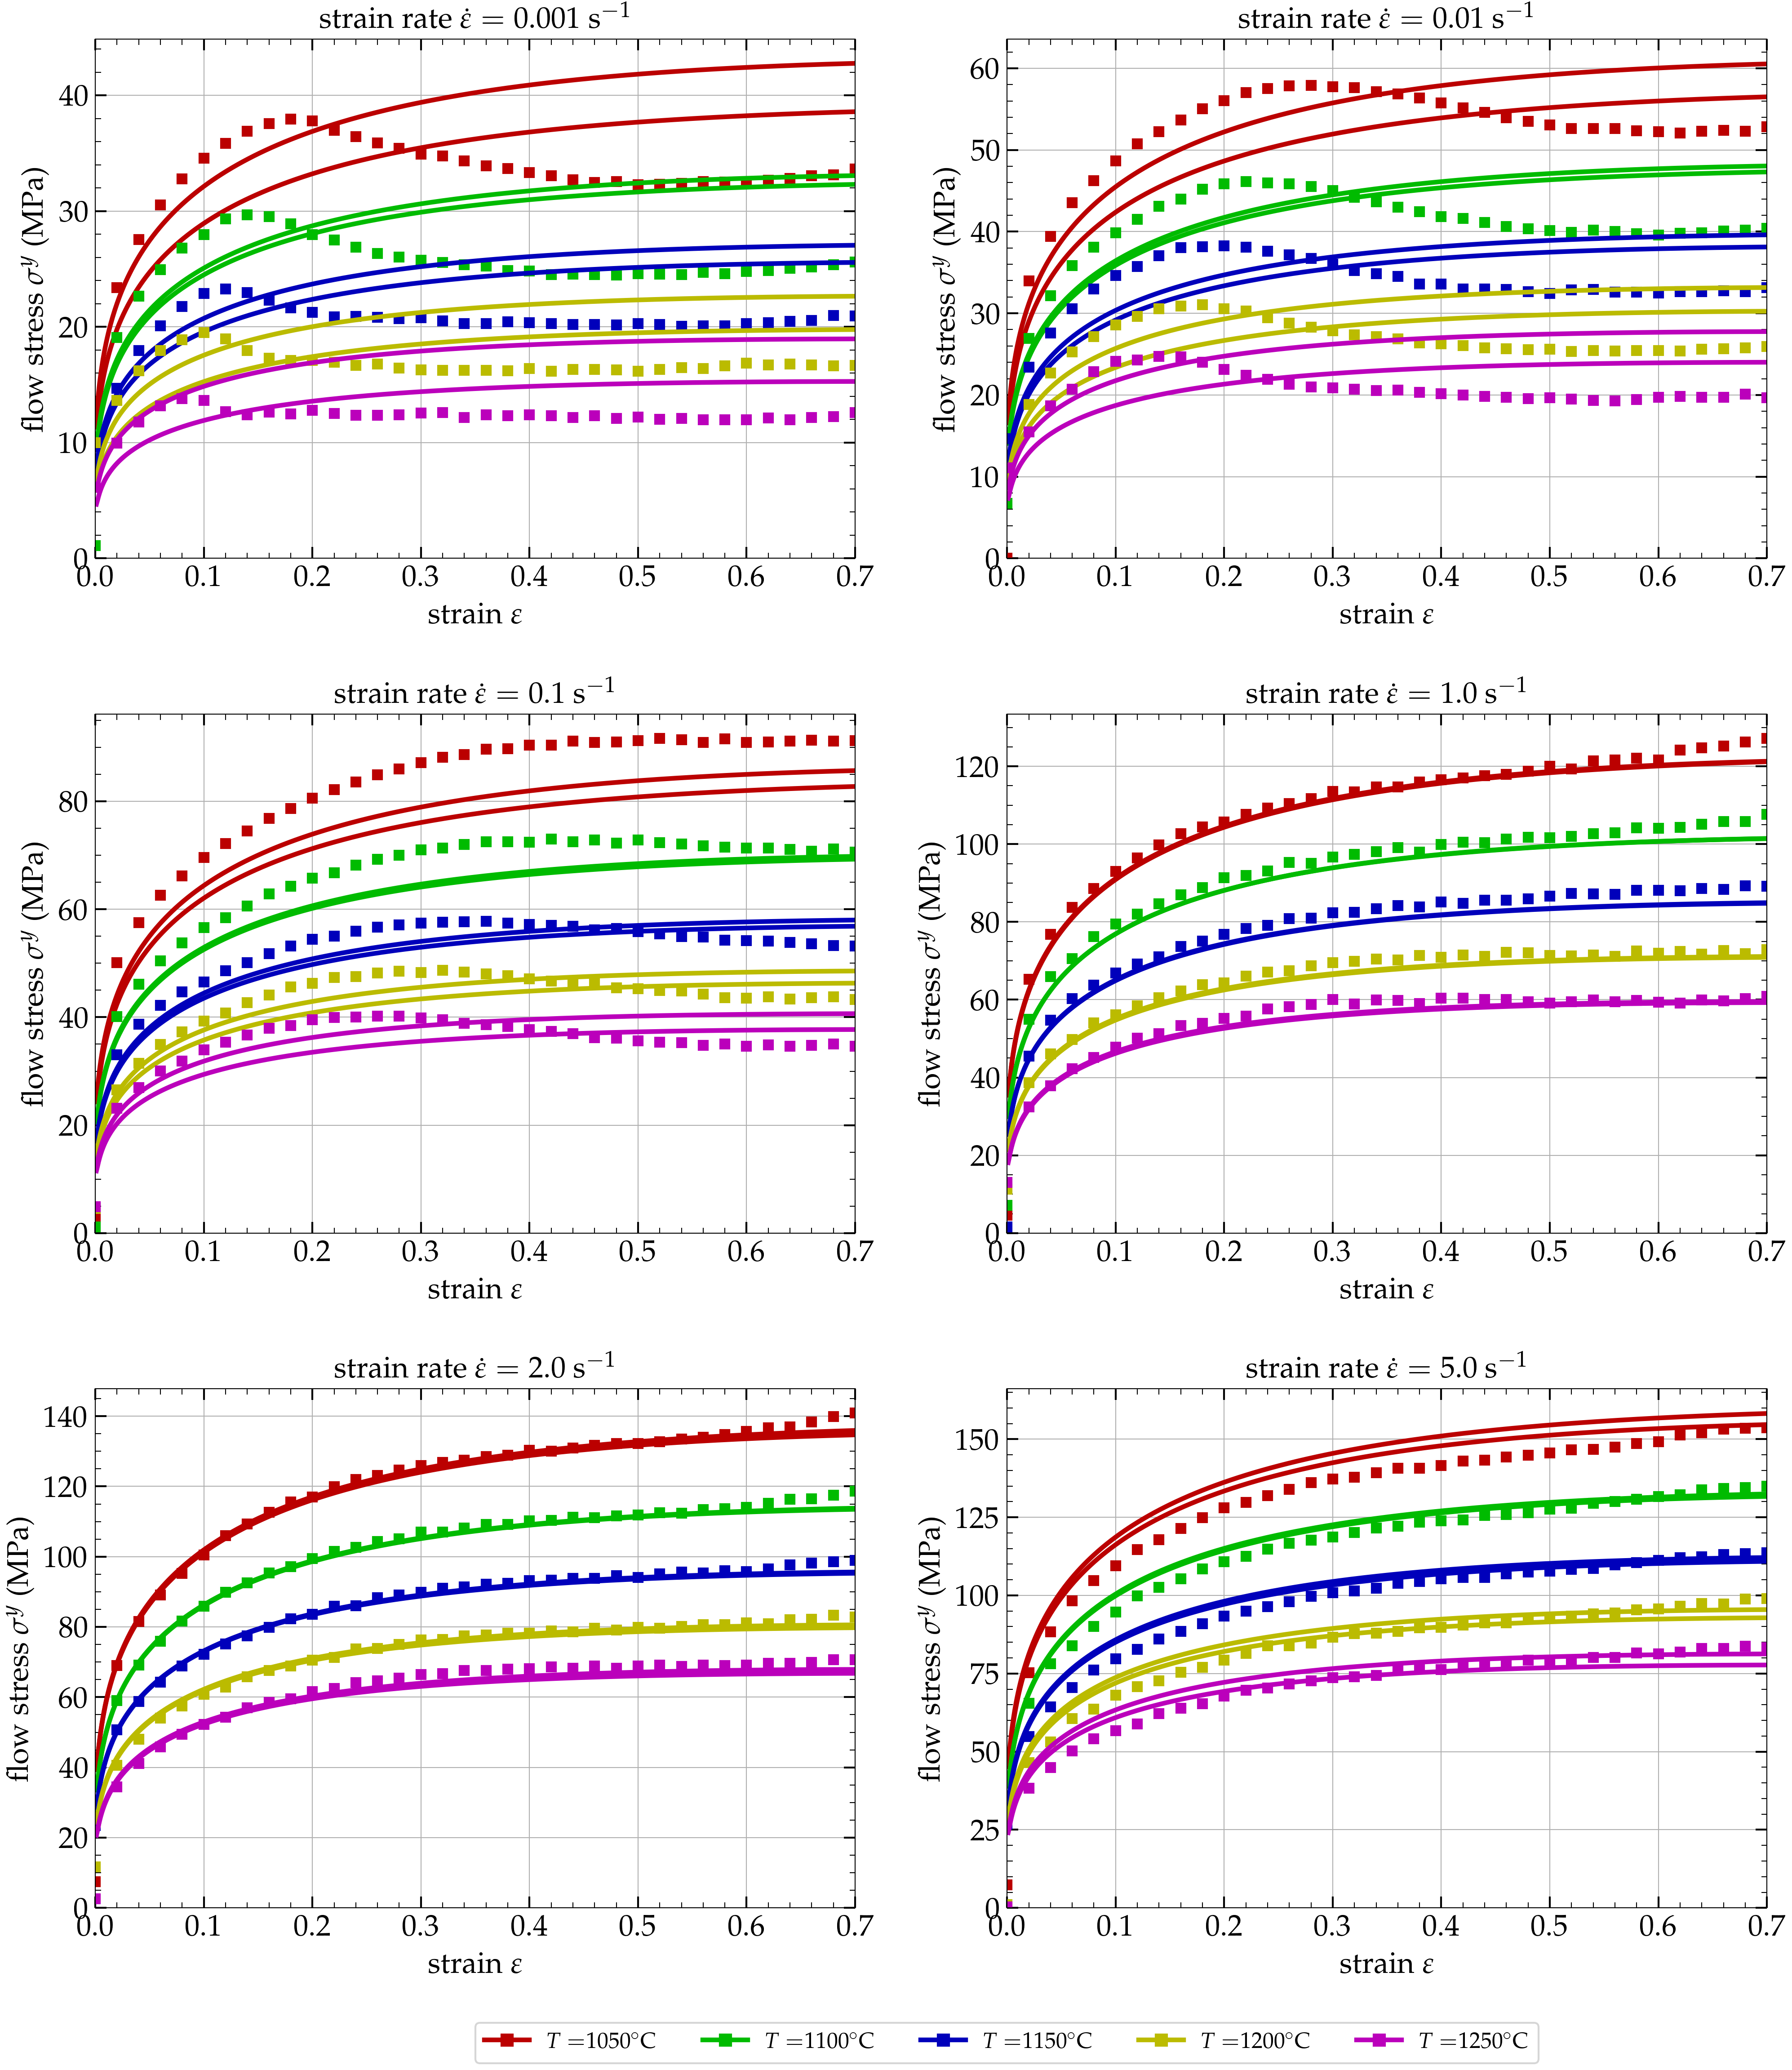

In [21]:
# Plot the curves
from matplotlib.lines import Line2D
def create_dummy_line(**kwds):
    return Line2D([], [], **kwds)

plt.figure(figsize = sbPlotSize(nEpsp))
plt.rc('text', usetex = True)
idx = 1
plt.subplots_adjust(hspace = 0.3)
for epsp in list(epsps):
    xs, ys = sbPlot(nEpsp)
    plt.subplot(xs, ys, idx)
    sbdata = shortData[shortData[:,1] == epsp]
    cl =0
    for temp in list(temperatures):
        sbdata1 = sbdata[sbdata[:,2] == temp]
        plt.plot(sbdata1[:,0], sbdata1[:,3], colors[cl], marker = 's', markersize = 5, linestyle = 'none')
        plt.plot(strains, HS5(strains, epsp, temp, fit5.params), colors[cl], linewidth = 2.5)
        #plt.plot(strains, HS6(strains, epsp, temp, fit6.params), colors[cl], linewidth = 2.5)
        plt.plot(strains, HS7(strains, epsp, temp, fit7.params), colors[cl], linewidth = 2.5)
        #plt.plot(strains, HS8(strains, epsp, temp, fit8.params), colors[cl], linewidth = 2.5)
        plt.rcParams['xtick.labelsize'] = 16
        plt.rcParams['ytick.labelsize'] = 16
        cl += 1
    plt.xlim(0, 0.7)
    plt.ylim(bottom = 0)
    plt.xlabel(r'strain $\varepsilon$', fontsize = 16) # Labels the x axis
    plt.ylabel(r'flow stress $\sigma^y$ (MPa)', fontsize = 16) # Labels the y axis
    plt.title(r'strain rate $\dot{\varepsilon} = ' + str(epsp) + '$ s$^{-1}$', fontsize = 16) # Self explicit command
    idx += 1

legendLines = []
cl = 0
for temp in list(temperatures):
    legendLines.append((r'$T=$' + str(int(temp)) + r'$^{\circ}$C', {'color':colors[cl], 'linestyle':'-', 'linewidth':2.5, 'marker':'s'}))
    cl += 1

plt.legend([create_dummy_line(**l[1]) for l in legendLines],[l[0] for l in legendLines], 
           loc = 'upper center', fontsize = 12, ncols = 5, bbox_to_anchor = (0.0, -0.2), shadow = False)

plt.savefig("CompExpHS.svg")
plt.show()

In [18]:
HS5stress = HS5(identData[:,0], identData[:,1], identData[:,2], fit5.params)
HS6stress = HS6(identData[:,0], identData[:,1], identData[:,2], fit6.params)
HS7stress = HS7(identData[:,0], identData[:,1], identData[:,2], fit7.params)
HS8stress = HS8(identData[:,0], identData[:,1], identData[:,2], fit8.params)

In [19]:
EAAR5 = np.sum(np.abs((identData[:,3] - HS5stress)/(identData[:,3])))*100/HS5stress.shape[0]
EAAR6 = np.sum(np.abs((identData[:,3] - HS6stress)/(identData[:,3])))*100/HS6stress.shape[0]
EAAR7 = np.sum(np.abs((identData[:,3] - HS7stress)/(identData[:,3])))*100/HS7stress.shape[0]
EAAR8 = np.sum(np.abs((identData[:,3] - HS8stress)/(identData[:,3])))*100/HS8stress.shape[0]
print("EAAR5 = %g" %(EAAR5) + ' %')
print("EAAR6 = %g" %(EAAR6) + ' %')
print("EAAR7 = %g" %(EAAR7) + ' %')
print("EAAR8 = %g" %(EAAR8) + ' %')

EAAR5 = 9.30313 %
EAAR6 = 9.30295 %
EAAR7 = 7.74881 %
EAAR8 = 7.74318 %


In [20]:
RMSE5 = np.sqrt(np.sum((identData[:,3] - HS5stress)**2)/HS5stress.shape[0])
RMSE6 = np.sqrt(np.sum((identData[:,3] - HS6stress)**2)/HS6stress.shape[0])
RMSE7 = np.sqrt(np.sum((identData[:,3] - HS7stress)**2)/HS7stress.shape[0])
RMSE8 = np.sqrt(np.sum((identData[:,3] - HS8stress)**2)/HS8stress.shape[0])
print('RMSE5 = %g' %(RMSE5)+' MPa')
print('RMSE6 = %g' %(RMSE6)+' MPa')
print('RMSE7 = %g' %(RMSE7)+' MPa')
print('RMSE8 = %g' %(RMSE8)+' MPa')

RMSE5 = 4.31043 MPa
RMSE6 = 4.31043 MPa
RMSE7 = 3.7999 MPa
RMSE8 = 3.79872 MPa
